In [143]:
!pip install -q jax flax numpy tqdm
import jax, jax.numpy as jnp, numpy as np
import flax.struct
from typing import NamedTuple, Optional
from tqdm import tqdm
from matplotlib import pyplot as plt

/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [144]:
from typing import Sequence


def draw_ternary(key: jax.random.PRNGKey, sparsity: float, shape: Sequence[int]):
    """Draw a random ternary vector."""
    subkey1, subkey2, subkey3 = jax.random.split(key, 3)
    n_tot = jnp.prod(jnp.array(shape))

    # pick random indices to update
    # the number of neurons to update is drawn from a Binomial distribution (but at least one)
    nnz = jax.random.binomial(subkey1, n_tot-1, sparsity).astype(int)+1
    # index of the neurons to update is drawn without replacement
    idx = jax.random.choice(subkey2, n_tot, (nnz,), replace=False)
    # the direction is a coin flip
    val = jax.random.randint(subkey3, (nnz,), 0, 2) * 2 - 1

    vec = jnp.zeros(n_tot)
    if nnz > 0:
        vec = vec.at[idx].set(val)

    return vec.reshape(shape)

In [204]:


class CIRRAM(object):
    """Compute-in-Resistive-RAM (CIRRAM) model."""

    class Parameters(NamedTuple):
        """CIRRAM model parameters."""
        offsets: jnp.ndarray
        ranges: jnp.ndarray
        sensitivities: jnp.ndarray
        drift: jnp.ndarray
        diffusion: jnp.ndarray
        gain: jnp.ndarray

    class State(NamedTuple):
        """CIRRAM model state."""
        control: jnp.ndarray

    def __init__(
        self,
        key: jax.random.PRNGKey,
        shape: tuple[int, int],
        initial: Optional[jnp.ndarray] = None,
        gain: Optional[jnp.ndarray] = None,
        offsets: Optional[jnp.ndarray] = None,
        ranges: Optional[jnp.ndarray] = None,
        sensitivities: Optional[jnp.ndarray] = None,
        drift: Optional[jnp.ndarray] = None,
        diffusion: Optional[jnp.ndarray] = None,    
    ):
        """Initialize the CIRRAM model."""

        # Make sure the shape is valid
        assert len(shape) == 2, "Only 2D arrays are supported."
        self.shape = shape

        # Initialize parameters
        initial = initial if initial is not None else jax.random.normal(key, shape)
        gain = gain if gain is not None else jnp.ones(())
        offsets = offsets if offsets is not None else jnp.zeros(shape)
        ranges = ranges if ranges is not None else jnp.ones(shape)
        sensitivities = sensitivities if sensitivities is not None else jnp.ones(shape)
        drift = drift if drift is not None else jnp.zeros(shape)
        diffusion = diffusion if diffusion is not None else jnp.zeros(shape)

        # Broadcast initial state to the desired shape
        initial = jnp.broadcast_to(initial, shape)

        # Now broadcast all parameters to the same shape
        initial, offsets, ranges, sensitivities, drift, diffusion = jnp.broadcast_arrays(
            initial, offsets, ranges, sensitivities, drift, diffusion
        )

        # Make sure all parameters have the same shape
        assert initial.shape == offsets.shape == ranges.shape == sensitivities.shape == drift.shape == diffusion.shape == shape, \
            f"All parameters must have the same shape ({shape})."

        # Store the parameters
        self.params = CIRRAM.Parameters(offsets, ranges, sensitivities, drift, diffusion, gain=gain)

        # Store the initial state
        self.state = CIRRAM.State(control=initial)

    @staticmethod
    def sample_dState(key: jax.random.PRNGKey, state: State, params: Parameters, inp: jnp.ndarray, sparsity: float) -> State:
        """Draw a random update for the CIRRAM model."""

        # draw a random update vector for the output nodes
        output_vector = draw_ternary(key, sparsity, (state.control.shape[0],))

        # compute the outer product of the input and output vectors
        outer = jnp.outer(output_vector, inp)

        return CIRRAM.State(control=outer)

    @staticmethod
    def conductance(state: State, params: Parameters) -> jnp.ndarray:
        """Compute the conductance of the CIRRAM model."""
        return params.offsets + jnp.multiply(params.ranges, jnp.tanh(jnp.multiply(params.sensitivities, state.control)))

    @staticmethod
    def diff_conductance(state: State, params: Parameters) -> jnp.ndarray:
        """Compute the effective differential conductance of the CIRRAM model."""
        cond = CIRRAM.conductance(state, params)
        # columns in memory alternate between being treated as positive and negative currents
        return (cond[0::2,...]-cond[1::2,...])
    
    @staticmethod
    def matmul(state: State, params: Parameters, voltage: jnp.ndarray) -> jnp.ndarray:
        """Multiply the effective differential conductance of the CIRRAM model by an input."""
        cond = CIRRAM.diff_conductance(state, params)
        # cond /= jnp.linalg.norm(cond)
        cond *= 2 / cond.shape[1]
        return cond @ voltage
    
    @staticmethod
    def update(state: State, dState: State, rate: float = 1.0) -> State:
        """Update the state of the CIRRAM model."""
        return CIRRAM.State(control=state.control + rate*dState.control)
    
    @staticmethod
    def forward(state, params, x: jnp.ndarray):
        """Forward pass of the single-layer CIRRAM model."""
        return CIRRAM.matmul(state, params, x) * params.gain

    @staticmethod
    def mse_loss(state, params, x: jnp.ndarray, y: jnp.ndarray, axis=None):
        """MSE loss of the single-layer CIRRAM model."""
        return jnp.mean(jnp.square(CIRRAM.forward(state, params, x) - y), axis=axis)
    
    @staticmethod
    def mse_train_gd(state: State, params: Parameters, x, y, rate=1e-3, steps=1000) -> tuple[State, jnp.ndarray]:
        loss_dloss=jax.jit(jax.value_and_grad(CIRRAM.mse_loss, argnums=0))
        """Train the single-layer CIRRAM model using gradient descent."""

        losses = []
        for _ in (bar := tqdm(range(steps))):
            loss, dloss = loss_dloss(state, params, x, y)
            state = CIRRAM.update(state, dloss, -rate)
            bar.set_postfix(loss=loss)
            losses.append(loss)
        return state, jnp.array(losses)

# Single linear layer

In [236]:
# generate data for example problem
num_dims = (5,5)
num_cirram_dims = (num_dims[0]*2, num_dims[1]) # (first dimension is doubled, because we have positive and negative weights)
num_samples = 10000
num_steps = 10000
noise_std = 10
mat = jnp.array(np.random.rand(*num_dims)-0.5)
x = jnp.array(np.random.randn(num_dims[1], num_samples))
y = mat @ x

## Without offsets

In [237]:
# Initialize the CIRRAM model
ram = CIRRAM(jax.random.PRNGKey(0), shape=num_cirram_dims, gain=1/(num_dims[1]*1))

# train the model
ram.state, loss_nomm = CIRRAM.mse_train_gd(ram.state, ram.params, x, y, rate=1e-1, steps=num_steps)

100%|██████████| 10000/10000 [00:05<00:00, 1803.26it/s, loss=0.18720308]


## With offsets

100%|██████████| 10000/10000 [00:05<00:00, 1979.68it/s, loss=6.210405]


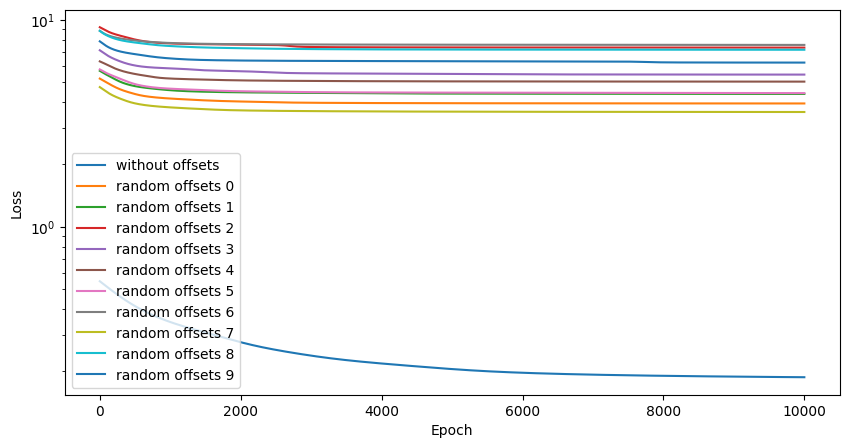

In [247]:
plt.figure(figsize=(10,5))
plt.semilogy(loss_nomm, label="without offsets")

# Now do the same thing, but this time with noisy offsets
num_trials = 10
k1,k2 = jax.random.split(jax.random.PRNGKey(0), 2)
for key1, key2, trial in zip(jax.random.split(k1, num_trials),jax.random.split(k2, num_trials),range(num_trials)):
    ram = CIRRAM(key=key1, shape=num_cirram_dims, offsets=noise_std*jax.random.normal(key2, num_cirram_dims), gain=1/(num_cirram_dims[1]*1))
    # train the model
    ram.state, loss_mm = CIRRAM.mse_train_gd(ram.state, ram.params, x, y, rate=1e-1, steps=num_steps)
    plt.semilogy(loss_mm, label=f'random offsets {trial}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Feed-forward linear neural network

In [239]:
from dataclasses import dataclass


@dataclass
class MultiLayerCIRRAM:
    state: list[CIRRAM.State]
    params: list[CIRRAM.Parameters]

    @staticmethod
    def from_layers(layers: list[CIRRAM]):
        return MultiLayerCIRRAM([layer.state for layer in layers], [layer.params for layer in layers])

    @staticmethod
    def forward(state: list[CIRRAM.State], params: list[CIRRAM.Parameters], x: jnp.ndarray) -> jnp.ndarray:
        """Forward pass of the multi-layer CIRRAM model."""
        for s, p in zip(state, params):
            x = CIRRAM.forward(s, p, x)
        return x
    
    @staticmethod
    def forward_with_hidden(state: list[CIRRAM.State], params: list[CIRRAM.Parameters], x: jnp.ndarray) -> jnp.ndarray:
        """Forward pass of the multi-layer CIRRAM model."""
        hidden = [x]
        for s, p in zip(state, params):
            x = CIRRAM.forward(s, p, x)
            hidden.append(x)
        return hidden
    
    @staticmethod
    def sample_dState(key: jax.random.PRNGKey, state: list[CIRRAM.State], params: list[CIRRAM.Parameters], inp: jnp.ndarray, sparsity: float) -> list[CIRRAM.State]:
        """Draw a random update for the multi-layer CIRRAM model."""
        subkeys = jax.random.split(key, len(state))

        # recompute all layer inputs
        layer_inp = MultiLayerCIRRAM.forward_with_hidden(state, params, inp)[:-1]
        return [CIRRAM.sample_dState(k, s, p, l, sparsity) for k, s, p, l in zip(subkeys, state, params, layer_inp)]

    @staticmethod
    def update(state: list[CIRRAM.State], dState: list[CIRRAM.State], rate: float = 1.0) -> list[CIRRAM.State]:
        """Update the state of the multi-layer CIRRAM model."""
        return [CIRRAM.update(s, d, rate) for s, d in zip(state, dState)]

    @staticmethod
    def mse_loss(state, params, x: jnp.ndarray, y: jnp.ndarray, axis=None) -> float:
        """MSE loss of the multi-layer CIRRAM model."""
        return jnp.mean(jnp.square(MultiLayerCIRRAM.forward(state, params, x) - y), axis=axis)

    @staticmethod
    def mse_train_gd(
        state: list[CIRRAM.State],
        params: list[CIRRAM.Parameters],
        x: jnp.ndarray,
        y: jnp.ndarray,
        rate=1e-3,
        steps=1000
    ) -> tuple[list[CIRRAM.State], jnp.ndarray]:
        """Train the multi-layer CIRRAM model using gradient descent."""
        # compile loss and gradient function
        loss_dloss=jax.jit(jax.value_and_grad(MultiLayerCIRRAM.mse_loss, argnums=0))

        losses = []
        for _ in (bar := tqdm(range(steps))):
            # compute loss and gradient
            loss, dloss = loss_dloss(state, params, x, y)
            # update the model in negative gradient direction
            state = MultiLayerCIRRAM.update(state, dloss, -rate)
            # update progress bar
            bar.set_postfix(loss=loss)
            losses.append(loss)

        return state, jnp.array(losses)
    

    @staticmethod
    def mse_train_metropolis(
        key: jax.random.PRNGKey, 
        params: list[CIRRAM.State], 
        state: list[CIRRAM.State], 
        x: jnp.ndarray, 
        y: jnp.ndarray, 
        sparsity=1/4, 
        rate=1e-3, 
        steps=1000,
        temperature=10.0
    ) -> tuple[list[CIRRAM.State], jnp.ndarray, jnp.ndarray]:
        """Train the multi-layer CIRRAM model using gradient descent."""
        # compile loss function
        loss = jax.jit(MultiLayerCIRRAM.mse_loss)
        
        # compute loss before the first update
        loss_after = loss(state, params, x, y)

        accepted = 0
        rejected = 0
        loss_logger = [],[]
        for _ in (bar := tqdm(range(steps))):
            key, subkey1, subkey2 = jax.random.split(key, 3)
            loss_before = loss_after

            # sample a data point
            xs = x[:, jax.random.randint(subkey1, (1,), 0, x.shape[1])[0]]

            # generate a random state update for the model
            dState = MultiLayerCIRRAM.sample_dState(key, state, params, xs, sparsity)

            # update the model in direction of the suggested update
            new_state = MultiLayerCIRRAM.update(state, dState, rate)

            # compute loss after the update
            loss_after = loss(new_state, params, x, y)

            # compute the acceptance probability
            accept_prob = jax.lax.clamp(0.0, jnp.exp(temperature*(loss_before - loss_after)), 1.0)

            # accept the new state with the given probability, otherwise go back
            accept = jax.random.bernoulli(subkey2, accept_prob)
            state = jax.lax.cond(accept, lambda: new_state, lambda: state)

            # print("Loss before:", loss_before, "Loss after:", loss_after, "Acceptance probability:", accept_prob, "Accept:", accept)
            loss_after = jax.lax.cond(accept, lambda: loss_after, lambda: loss_before)

            if accept:
                accepted += 1
            else:
                rejected += 1
            acceptance_ratio = accepted / (rejected + accepted)

            bar.set_postfix({"Loss:": loss_after, "Acceptance ratio": acceptance_ratio})

            if loss_logger is not None:
                loss_logger[0].append(loss_after)
                loss_logger[1].append(accept)
                    
        return state, jnp.array(loss_logger[0]), jnp.array(loss_logger[1])
    

In [240]:
num_layer_dims = [num_dims[1], 100, num_dims[0]]
num_cirram_layer_dims = [(2*o, i) for (o, i) in zip(num_layer_dims[1:], num_layer_dims[:-1])]
key1,key2 = jax.random.split(jax.random.PRNGKey(0), 2)
subkeys1 = jax.random.split(key1, len(num_cirram_layer_dims))
subkeys2 = jax.random.split(key2, len(num_cirram_layer_dims))

fixed_summation_weights = lambda shape: jnp.ones(shape).at[1::2,...].set(0)
random_weights = lambda key, shape: noise_std*jax.random.normal(key, shape)
net_gd = MultiLayerCIRRAM.from_layers([
    CIRRAM(k1, shape=shape, offsets=(random_weights(k2, shape) if l == 0 else fixed_summation_weights(shape)), ranges=None if l == 0 else jnp.zeros(shape), gain=1/(shape[1]*1))
    for l, (k1, k2, shape) in enumerate(zip(subkeys1, subkeys2, num_cirram_layer_dims))
])

In [241]:
# train the model
net_gd.state, loss = MultiLayerCIRRAM.mse_train_gd(net_gd.state, net_gd.params, x, y, rate=1e-0, steps=10000)

100%|██████████| 10000/10000 [00:25<00:00, 388.89it/s, loss=0.5007265]


In [242]:
net_gd.params[1].gain

0.01

In [243]:
# Test the result for a bunch of different inputs
x = jnp.array(np.random.randn(num_layer_dims[0], num_samples))
y = mat @ x
MultiLayerCIRRAM.mse_loss(net_gd.state, net_gd.params, x, y)

Array(0.49439597, dtype=float32)

In [244]:
MultiLayerCIRRAM.forward_with_hidden(net_gd.state, net_gd.params, x[:,0])

[Array([-0.7501236 , -0.5541877 ,  2.1244164 ,  0.44883686, -1.386376  ],      dtype=float32),
 Array([-0.70053566, -2.585298  ,  1.1455973 , -0.9183454 ,  2.0316656 ,
         1.929736  , -1.0696217 ,  3.406279  ,  2.395395  ,  3.9982479 ,
         0.4946606 , -7.319558  , -3.5167692 , -1.4735657 , -0.3842373 ,
        -3.8446274 , -3.849078  ,  1.9730256 ,  0.09539872, -0.48749027,
        -1.5096072 ,  0.14023371, -1.5239648 , -2.4673693 ,  0.43904027,
        -3.3438013 , -1.9618584 , -3.074313  , -0.3200954 ,  2.4205506 ,
         6.3918676 , -1.8640785 , -5.549358  , -1.203698  , -2.3725896 ,
         1.1392857 ,  8.032824  ,  4.218422  , -2.2543848 , -2.5397432 ,
        -3.1216187 ,  4.7840776 ,  1.1568596 ,  0.49256727,  0.41712743,
         0.3938782 ,  0.92181885, -2.7261255 , -3.0454903 , -1.9364938 ,
        -1.9764837 , -0.83336556,  0.18310128, -1.8662941 , -4.091825  ,
        -1.394187  ,  1.6577011 ,  1.4374549 , -3.1467962 ,  4.1929398 ,
        -1.7734431 , -2.11019

We have controllable parameters $P$, uncontrollable device properties $Q$, and data $D=\{(x_i,y_i), i \in \mathbb{N}\}$, where ideally $l(y_i,f(x_i|P, Q))=0$ for some loss function $l$ and some function $f$ parameterized by $P$ and $Q$.

# approach 1 - approximate / optimize
## 2-phase:
* approximate $\hat P \approx P$ and $\hat Q \approx Q$ 
* then perform gradient descent with computed gradient $\frac{dl}{dP}(D,P,Q)$ and 

## interleaved:
* alternate between approximating $P$ and $Q$, and gradient steps

# approach 2 - Black-Box Metropolis
* from parameters $P$ sample $P\prime$
* evaluate $l(y,f(x|P\prime,Q))$
* if better, accept, if worse, accept with probability

In [245]:
# reinitialize the network
fixed_summation_weights = lambda shape: jnp.ones(shape).at[1::2,...].set(0)
random_weights = lambda key, shape: noise_std*jax.random.normal(key, shape)
net_bb = MultiLayerCIRRAM.from_layers([
    CIRRAM(k1, shape=shape, offsets=(random_weights(k2, shape) if l == 0 else fixed_summation_weights(shape)), ranges=None if l == 0 else jnp.zeros(shape), gain=1/(shape[1]*1))
    for l, (k1, k2, shape) in enumerate(zip(subkeys1, subkeys2, num_cirram_layer_dims))
])

# train the model with Metropolis-Hastings
mcmc_trained_statem, losses, accept = MultiLayerCIRRAM.mse_train_metropolis(jax.random.PRNGKey(0), net_bb.params, net_bb.state, x, y, sparsity=1/4, rate=1e-2, steps=1000, temperature=100.0)
net_bb.state = mcmc_trained_statem

100%|██████████| 1000/1000 [00:34<00:00, 28.86it/s, Loss:=0.49448326, Acceptance ratio=1]


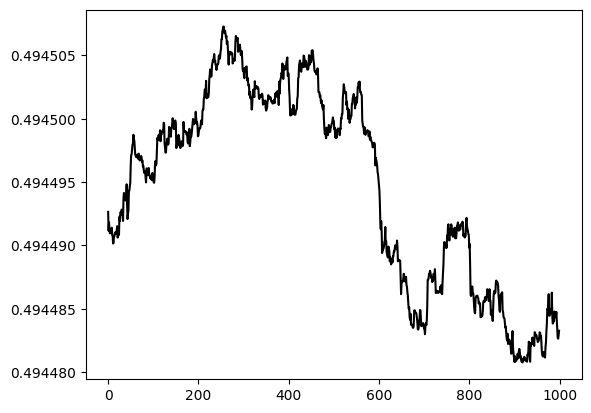

In [246]:
ss = np.arange(len(losses))
plt.plot(ss, losses, color="black")
plt.plot(ss[np.logical_not(accept)], losses[np.logical_not(accept)], marker="x", ls="none", markersize=4, color="red", alpha=0.5)